In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

In [46]:
# get filepath to matsim outputs in box,
#filepath = 'MATSim_Outputs'
filepath = '/Users/brynnwoolley/IMT_Research/BYU_imt_optimization/MATSim_Analysis/Outputs'
# load in scenario code values & make them into a list 
codes = pd.read_csv('codes.csv')
seed_dict = {row['Seed Value']: row['Number of Incidents'] for index, row in codes.iterrows()}
seed_numbers = [int(folder.split('_')[1]) for folder in os.listdir(filepath) if os.path.isdir(os.path.join(filepath, folder)) and folder.startswith('Seed_')]

# get processed seeds
seeds = [(key, value) for key, value in seed_dict.items() if key in seed_numbers]
#seeds = [(key, value) for key, value in seeds if (key, value) != (637, 19)]        # i don't think seed 637 is wonky anymore so commented out


# set up dictionary of column titles to print names
types = {'total_delay' : "Total Delay", 'total_tt': "Total Travel Time", 'total_user_benefits': "Total User Benefits", 'avg_executed': 'Avg Executed', 'avg_worst': 'Avg Worst', 'avg_avg': 'Avg Average', 'avg_best': 'Average Best'}
fleets = {1: 'No IMTs', 2: 'Curr IMTs', 3: 'More IMTs'}

In [52]:
# check that all the right output file seeds are listed
seeds

[(723, 4),
 (886, 5),
 (472, 21),
 (790, 11),
 (418, 11),
 (847, 11),
 (167, 18),
 (915, 18),
 (637, 19),
 (879, 19),
 (227, 19),
 (584, 20),
 (951, 20)]

### Data Frame Functions

In [9]:
def get_score_row(seed, imt_dep, num_inc, avg=0):
    """
    Arguments:
        seed (int): seed value for scenario
        imt_dep (int): 1 = no imts, 2 = current imts, 3 = improved imts
        num_inc (int): number of incidents
        avg (int): how many of the last iterations to average
    """
    if imt_dep == 1:
        filename = f'{filepath}/Seed_{seed}/Incidents_{imt_dep}-{num_inc}-{seed}/scorestats.txt'
    else:
        filename = f'/{filepath}/Seed_{seed}/IMT_{imt_dep}-{num_inc}-{seed}/scorestats.txt'

    try:
        # Attempt to open and process the file
        with open(filename, 'r') as file:
            # Your file processing code here
            df = pd.read_csv(filename, delimiter='\t', index_col=0)

            if avg == 0:
                return df[df.index==100]
            
            else:
                return df.iloc[-avg:, 0:].mean()
            
    except FileNotFoundError:
        # Handle the error by skipping the file
        index_values = ['avg. EXECUTED', 'avg. WORST', 'avg. AVG', 'avg. BEST']
        nan_series = pd.Series(np.nan, index=index_values)
        return nan_series

def get_score_df(n=0):
    
    list = []
    for (seed, inc) in seeds:
        for i in range(1,4):
            row = get_score_row(seed, i, inc, avg=n)
            code = f'{i}-{inc}-{seed}'

            avg_executed = float(row['avg. EXECUTED'])
            avg_worst = float(row['avg. WORST'])
            avg_avg = float(row['avg. AVG'])
            avg_best = float(row['avg. BEST'])

            new_row = [code, seed, fleets[i], i, inc, avg_executed, avg_worst, avg_avg, avg_best]
            list.append(new_row)

    data = pd.DataFrame(data=list, columns=['code', 'seed', 'fleet', 'fleet_code','incidents', 'avg_executed', 'avg_worst', 'avg_avg', 'avg_best'])
    data = data.dropna()

    if n == 0:
        data.name = 'Score values from 100th iteration'
    else:
        data.name = f'average of last {n} iterations scores values'

    return data

In [53]:
def get_vhd_row(seed, imt_dep, num_inc, avg=0):
    """
    Arguments:
        seed (int): seed value for scenario
        imt_dep (int): 1 = no imts, 2 = current imts, 3 = improved imts
        num_inc (int): number of incidents
        avg (int): how many of the last iterations to average
    """
    if imt_dep == 1:
        filename = f'{filepath}/Seed_{seed}/Incidents_{imt_dep}-{num_inc}-{seed}/null.decongestion_info.csv'
    else:
        filename = f'{filepath}/Seed_{seed}/IMT_{imt_dep}-{num_inc}-{seed}/null.decongestion_info.csv'

    try:
        # Attempt to open and process the file
        with open(filename, 'r') as file:
            # Your file processing code here
            #df = pd.read_csv(filename, delimiter=';', index_col=0)
            df = pd.read_csv(filename, index_col=0)

            if avg == 0:
                return df[df.index==100]
            
            else:
                return df.iloc[-avg:, 0:].mean()
            
    except FileNotFoundError:
        # Handle the error by skipping the file
        index_values = [' Total delay [hours] ', ' Total congestion toll payments [monetary units] ', ' Total travel time [hours]', ' Total user benefits [monetary units]', ' System welfare (only considering congestion toll revenues, other revenues are neglected [monetary units]']
        nan_series = pd.Series(np.nan, index=index_values)
        return nan_series

def get_vhd_df(n=0):

    list = []
    for (seed, inc) in seeds:
        for i in range(1,4):
            row = get_vhd_row(seed, i, inc, avg=n)
            code = f'{i}-{inc}-{seed}'
            
            total_delay = float(row[' Total delay [hours] '])
            total_tt = float(row[' Total travel time [hours]'])
            total_user_benefits = float(row[' Total user benefits [monetary units]'])
            system_welfare = float(row[' System welfare (only considering congestion toll revenues'])

            new_row = [code, seed, fleets[i], i, inc, total_delay, total_tt, total_user_benefits, system_welfare]
            list.append(new_row)

    data = pd.DataFrame(data=list, columns=['code', 'seed', 'fleet', 'fleet_code','incidents', 'total_delay', 'total_tt', 'total_user_benefits', 'system_welfare'])
    data = data.dropna()

    if n == 0:
        data.name = 'VHD values from 100th iteration'
    else:
        data.name = f'average of last {n} iterations VHD values'

    return data

In [54]:
get_vhd_df()

,code,seed,fleet,fleet_code,incidents,total_delay,total_tt,total_user_benefits,system_welfare
0,1-4-723,723,No IMTs,1,4,91849.31944,967555.0594,113000000.0,113000000.0
1,2-4-723,723,Curr IMTs,2,4,72790.26472,945886.6592,114000000.0,114000000.0
2,3-4-723,723,More IMTs,3,4,79511.87472,954278.7497,113000000.0,113000000.0
3,1-5-886,886,No IMTs,1,5,82937.95250,962883.4828,112000000.0,112000000.0
4,2-5-886,886,Curr IMTs,2,5,96217.56417,975281.1981,112000000.0,112000000.0
5,3-5-886,886,More IMTs,3,5,79775.83194,955221.3469,113000000.0,113000000.0
6,1-21-472,472,No IMTs,1,21,80597.36472,955472.9144,114000000.0,114000000.0
7,2-21-472,472,Curr IMTs,2,21,76017.26583,951183.9208,114000000.0,114000000.0
8,3-21-472,472,More IMTs,3,21,72650.89278,946551.7608,114000000.0,114000000.0
9,1-11-790,790,No IMTs,1,11,69989.95750,941201.4328,123000000.0,123000000.0


### Plotting Functions

In [50]:
def plot_vhd(index='seed', columns='fleet',values='total_delay', n=0):

    df = get_vhd_df(n)

    type = types[values]

    if n == 0:
        title = f'{type} from 100th iteration'
    else:
        title = f'Average of final {n} iterations {type}'
    # Pivot the data to create columns for each fleet value
    pivot_df = df.pivot(index=index, columns=columns, values=values)

    # Reindex columns to match the desired order
    desired_fleet_order = ['No IMTs', 'Curr IMTs', 'More IMTs']
    pivot_df = pivot_df.reindex(columns=desired_fleet_order)

    # Plot the data as a bar graph
    pivot_df.plot(kind='bar', figsize=(10, 6))
    plt.xlabel('Seed')
    plt.ylabel(f'{type} (hours)')
    plt.title(title)
    plt.legend(title='Fleet')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


    plt.show()


def plot_score(index='seed', columns='fleet',values='avg_executed', n=0):

    df = get_score_df(n)

    type = types[values]

    if n == 0:
        title = f'{type} from 100th iteration'
    else:
        title = f'Average of final {n} iterations of {type}'

    # Pivot the data to create columns for each fleet value
    pivot_df = df.pivot(index=index, columns=columns, values=values)

    # Reindex columns to match the desired order
    desired_fleet_order = ['No IMTs', 'Curr IMTs', 'More IMTs']
    pivot_df = pivot_df.reindex(columns=desired_fleet_order)

    # Plot the data as a bar graph
    pivot_df.plot(kind='bar', figsize=(10, 6))
    plt.xlabel('Seed')
    plt.ylabel(f'{type} score')
    plt.title(title)
    plt.legend(title='Fleet')

    #plt.legend().remove()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()


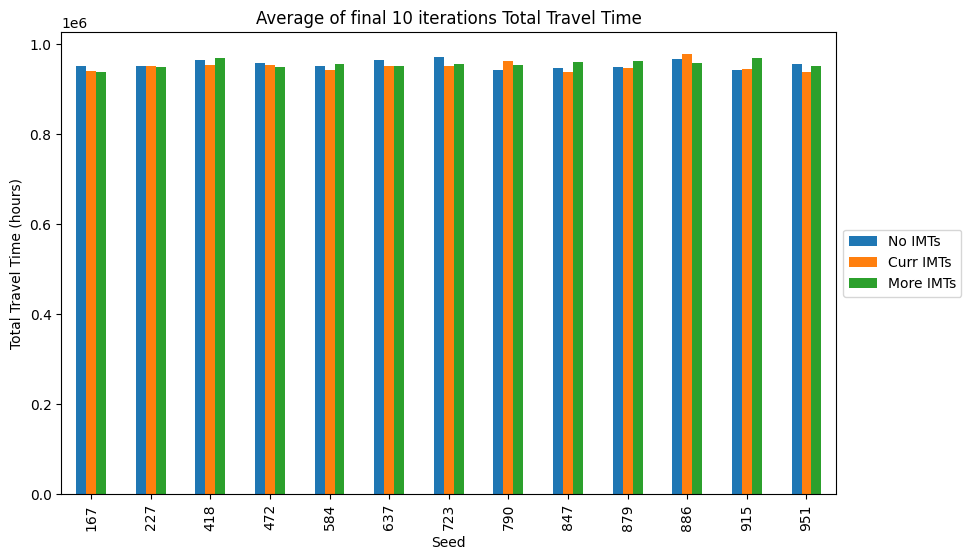

In [49]:
#plot_vhd(index='seed', columns='fleet',values='total_delay', n=10)
#plot_vhd(index='seed', columns='fleet',values='total_tt', n=10)
#plot_vhd(index='seed', columns='fleet',values='total_user_benefits', n=10)


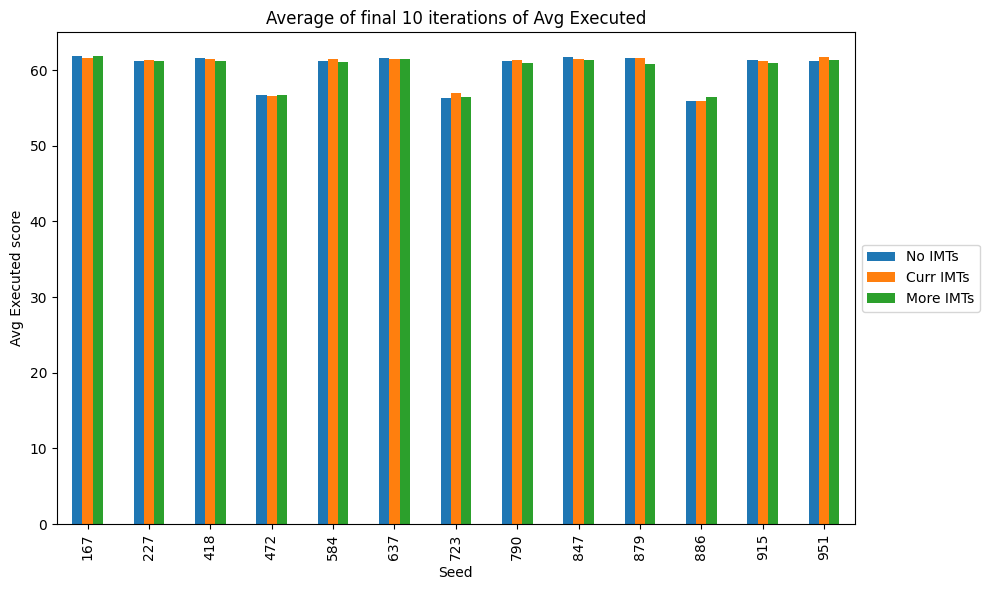

In [51]:
plot_score(n=10)
#plot_score(n=10, values='avg_worst')
#plot_score(n=10, values='avg_avg')
#plot_score(n=10, values = 'avg_best')
